### Упражнения

* Осуществите фильтрацию изображения при помощи среднего и среднего взвешенного фильтра с различным размером ядра. 
* Сравните результаты медианного и среднего фильтра на изображении с шумом соли и перца.
* Реализуйте медианный фильтр. Сравните с изображением, которое получается в результате применения функции cv2.medianBlur().
* Реализуйте метод conv2D для выполнения операции свертки со следующими параметрами: img (входное изображение), kernel (ядро свертки), padding (отступ, по умолчанию 0), stride (шаг, по умолчанию 1). Сравните с изображением, которое получается в результате применения функции cv2.filter2D().


In [1]:
import cv2 as cv
import PIL as p
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
def printFrame(frame):
    fig = plt.figure(figsize=(10,2),dpi=300)
    fig.add_subplot(1,3,1)
    plt.imshow(frame[0])
    fig.add_subplot(1,3,2)
    plt.imshow(frame[1])
    fig.add_subplot(1,3,3)
    plt.imshow(frame[2])

In [3]:
def printFrameGr(frame):
    fig = plt.figure(figsize=(10,2),dpi=300)
    fig.add_subplot(1,3,1)
    plt.imshow(frame[0],'gray')
    fig.add_subplot(1,3,2)
    plt.imshow(frame[1],'gray')
    fig.add_subplot(1,3,3)
    plt.imshow(frame[2],'gray')

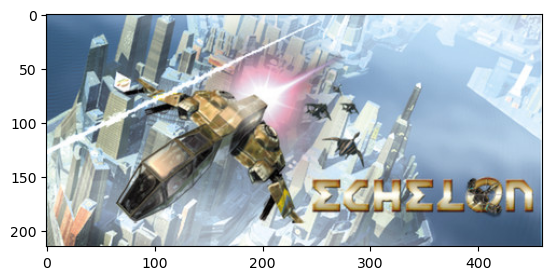

In [4]:
img = cv.imread('header.jpg')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)

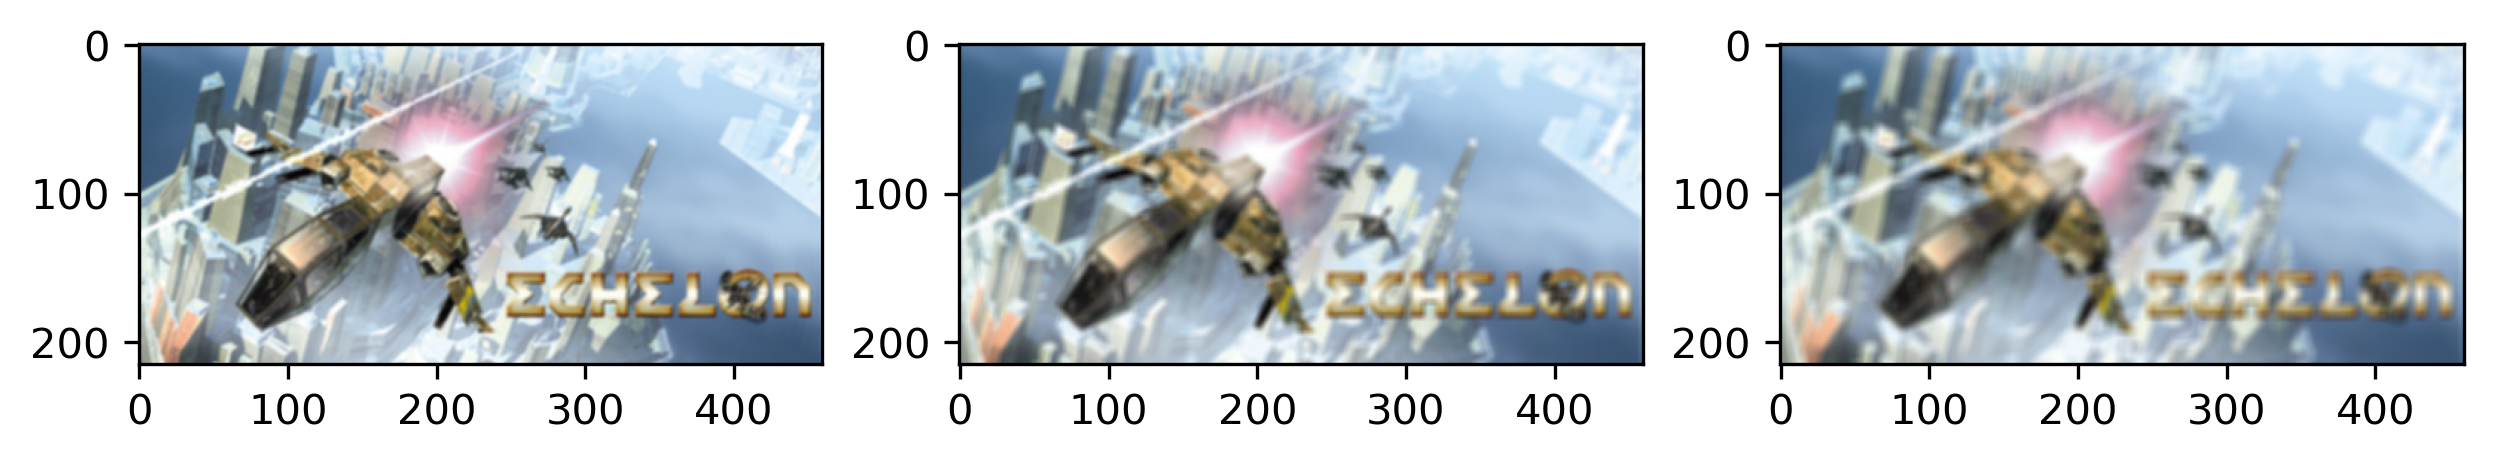

In [5]:
printFrame([cv.blur(img,(3,3)),cv.blur(img,(5,5)),cv.blur(img,(7,7))])

In [6]:
import math
def genOddKernel(size,centre):
    kernel = np.ones((size, size), dtype=np.float32)
    kernel[math.floor(size/2),math.floor(size/2)] = centre
    kernel /= np.sum(kernel)
    return kernel

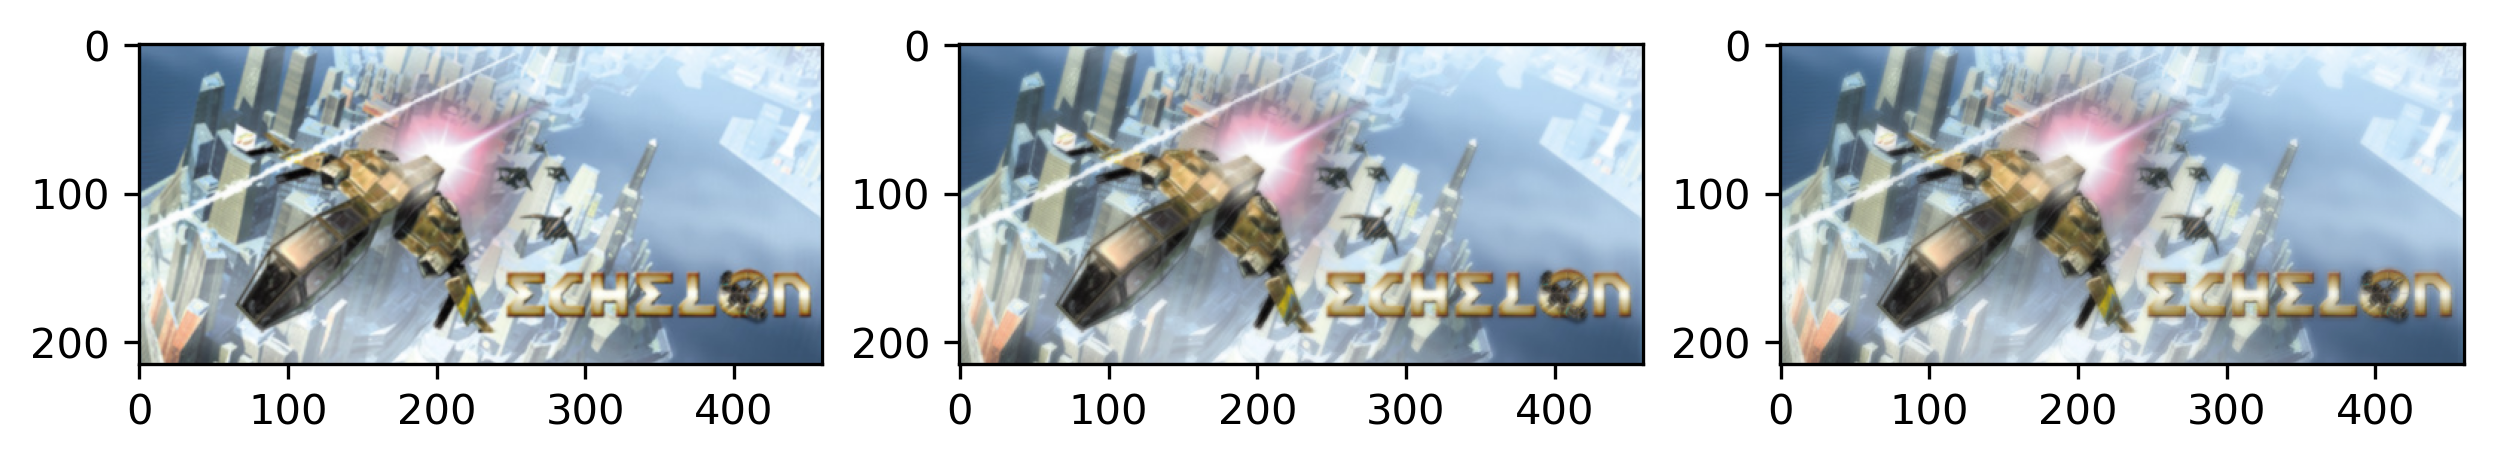

In [7]:
printFrame([cv.filter2D(img, -1, genOddKernel(3,9)),cv.filter2D(img, -1, genOddKernel(5,25)),cv.filter2D(img, -1, genOddKernel(7,49))])

In [8]:
def add_noise(img,vol=1000):
    import random
    random.seed(42)
    # Getting the dimensions of the image
    row , col = img.shape
      
    # Randomly pick some pixels in the
    # image for coloring them white
    # Pick a random number between 300 and 10000
    number_of_pixels = random.randint(vol, 10000)
    for i in range(number_of_pixels):
        
        # Pick a random y coordinate
        y_coord=random.randint(0, row - 1)
          
        # Pick a random x coordinate
        x_coord=random.randint(0, col - 1)
          
        # Color that pixel to white
        img[y_coord][x_coord] = 255
          
    # Randomly pick some pixels in
    # the image for coloring them black
    # Pick a random number between 300 and 10000
    number_of_pixels = random.randint(vol , 10000)
    for i in range(number_of_pixels):
        
        # Pick a random y coordinate
        y_coord=random.randint(0, row - 1)
          
        # Pick a random x coordinate
        x_coord=random.randint(0, col - 1)
          
        # Color that pixel to black
        img[y_coord][x_coord] = 0
    return img          

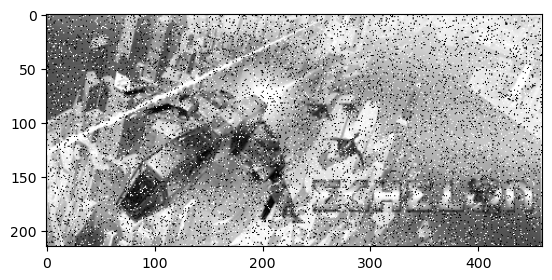

In [9]:
saltpaper = add_noise(cv.imread('header.jpg',cv.IMREAD_GRAYSCALE),5000)
plt.imshow(saltpaper,'gray')

In [10]:
def stackZeros(im,size):
    h = size // 2
    img1 = im.copy()
    img1 = np.vstack((np.zeros((h,img1.shape[1]),dtype=img1.dtype),img1,(np.zeros((h,img1.shape[1]),dtype=img1.dtype))))
    img1 = np.hstack((np.zeros((img1.shape[0],h),dtype=img1.dtype),img1,np.zeros((img1.shape[0],h),dtype=img1.dtype)))
    return img1

def getMedian(wind,img):
    return np.median(img[wind[0]:wind[1],wind[2]:wind[3]])

def medianFilterOdd(img,size):
    if size==1:
        return img
    f = np.vectorize(getMedian)
    offset = size // 2
    imgo = img.copy()
    expimg = stackZeros(img,size)
    #roi = np.fromfunction(lambda i, j: np.array([offset+i,offset+i+size,offset+j,offset+j+size]), img, dtype=img.dtype).swapaxes(0,-1)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            imgo[i,j] = np.median(expimg[i:i+size,j:j+size])
    return imgo

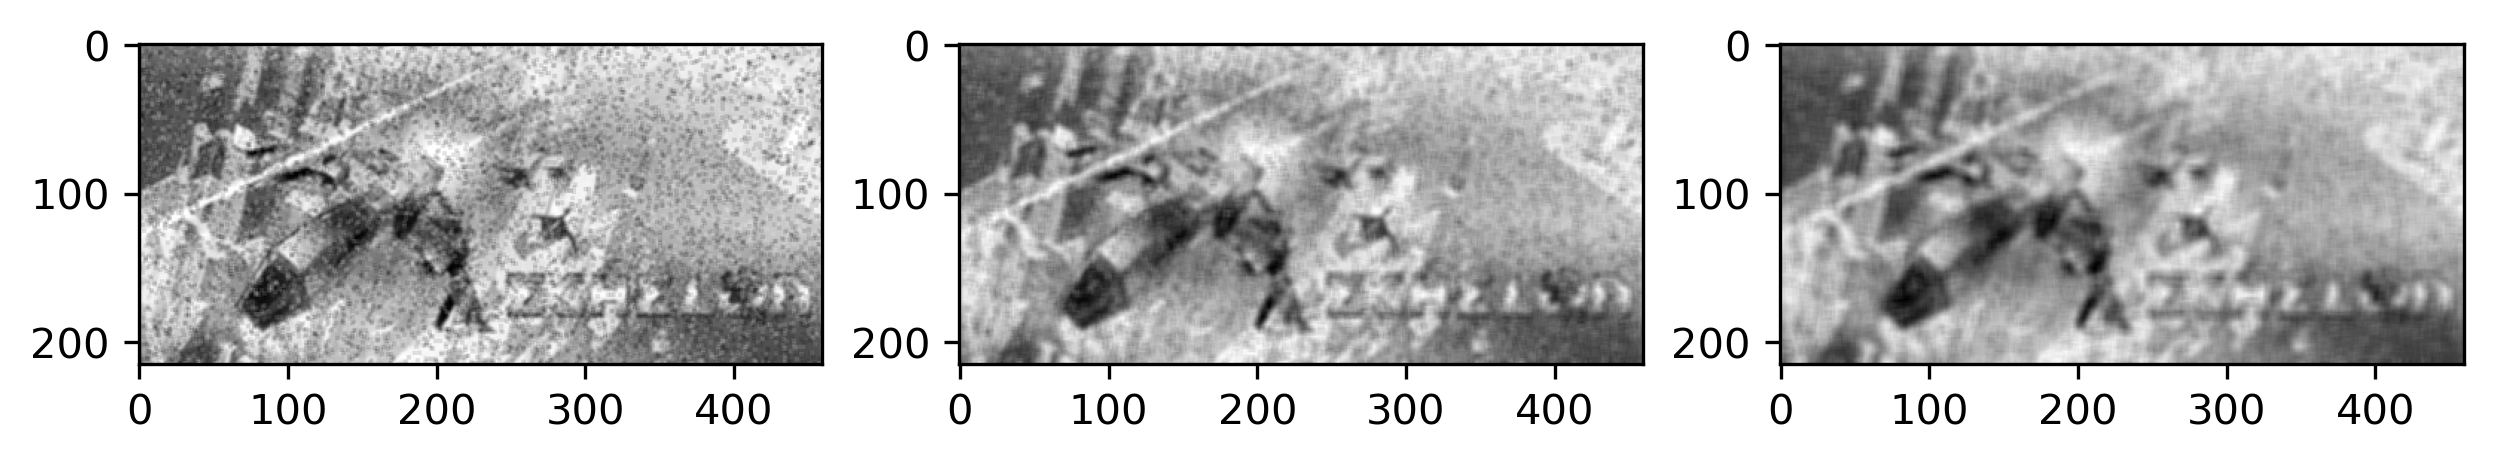

In [11]:
printFrameGr([cv.blur(saltpaper,(3,3)),cv.blur(saltpaper,(5,5)),cv.blur(saltpaper,(7,7))])


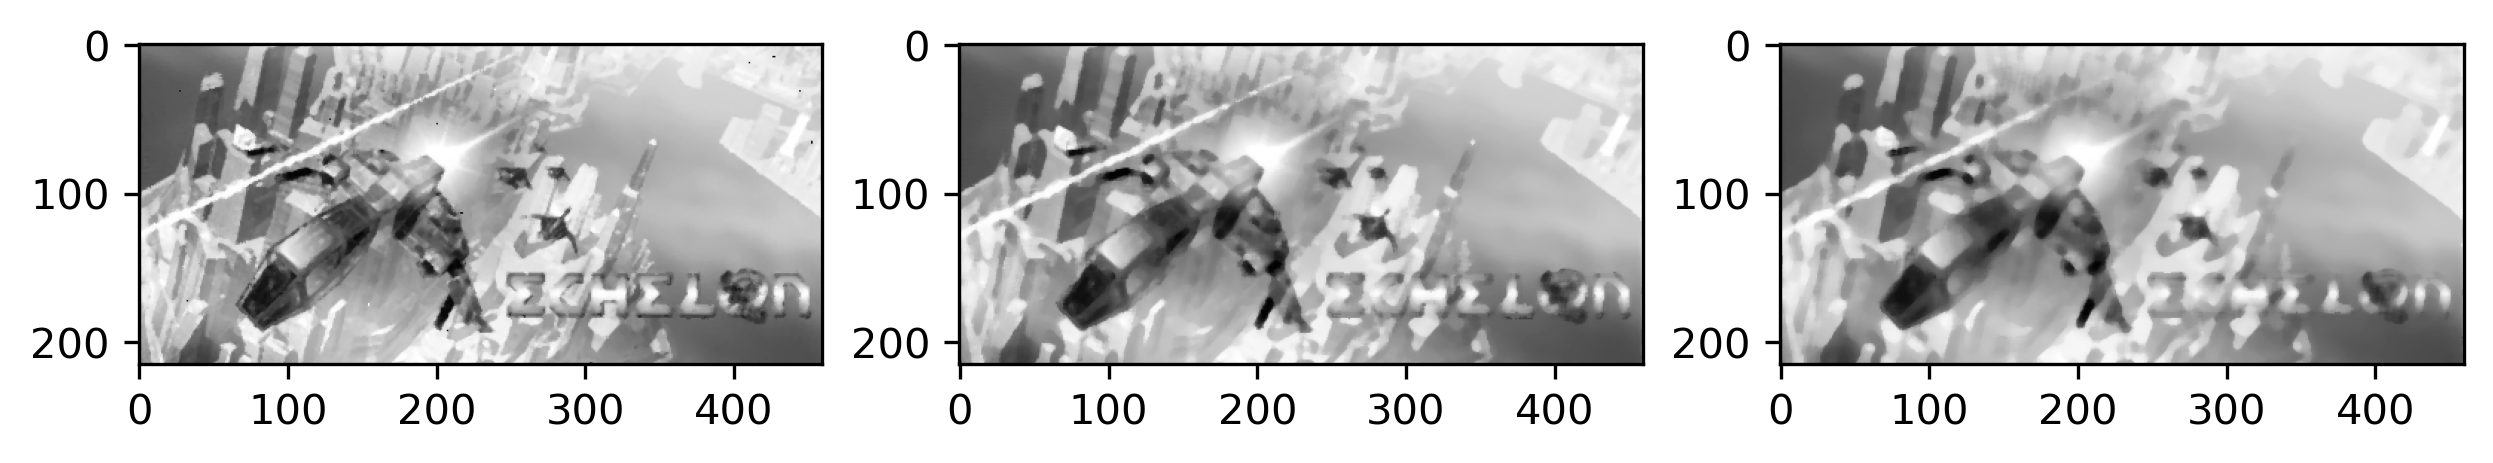

In [12]:
printFrameGr([cv.medianBlur(saltpaper,3),cv.medianBlur(saltpaper,5),cv.medianBlur(saltpaper,7)])


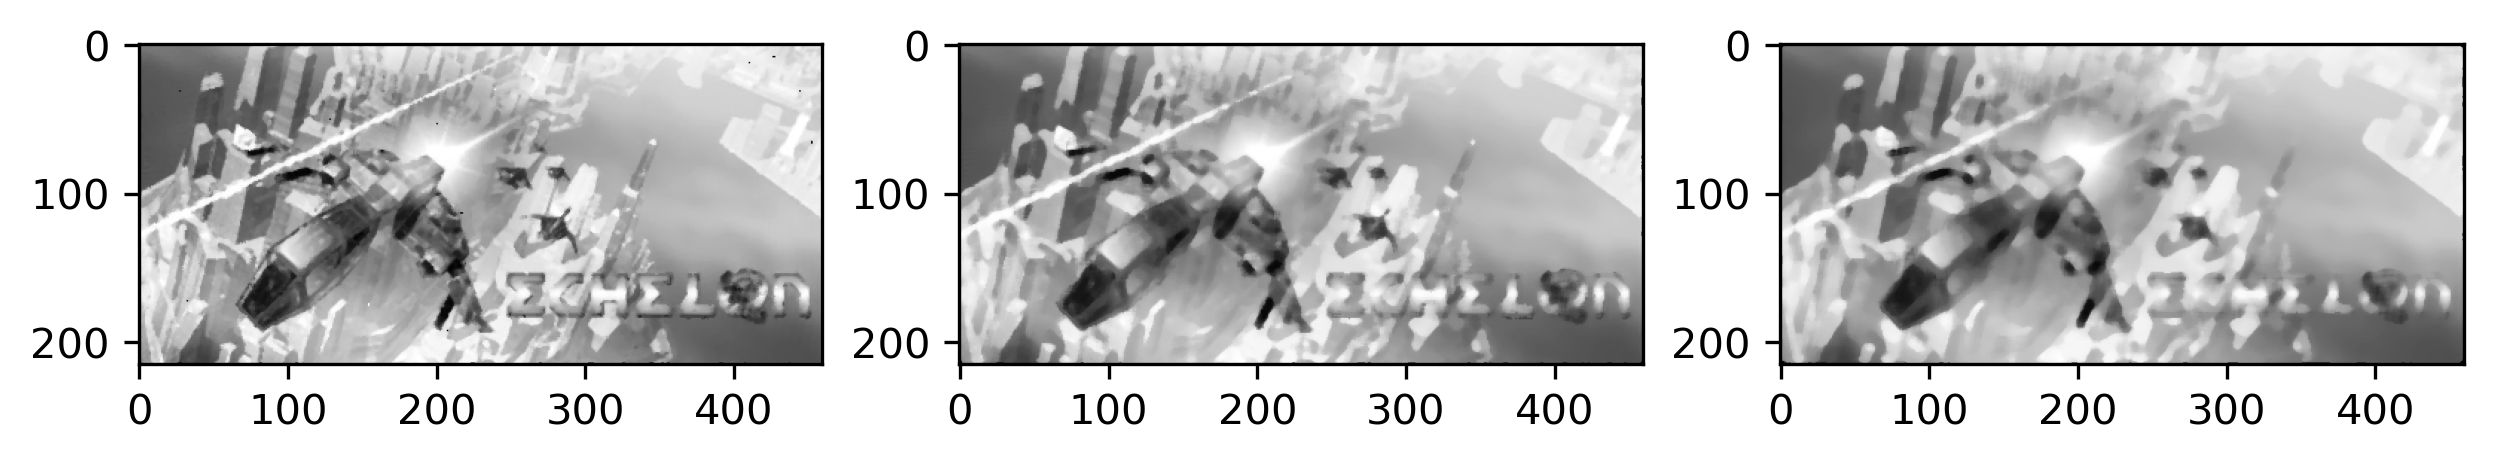

In [13]:
printFrameGr([medianFilterOdd(saltpaper,3),medianFilterOdd(saltpaper,5),medianFilterOdd(saltpaper,7)])

In [146]:
def applyKernel(img,kernel):
    arr = np.sum(img*kernel)
    return np.where(arr>0,arr,0)


def applyPudding(im,size):
    h = size
    img1 = im.copy()
    img1 = np.vstack((np.zeros((h,img1.shape[1]),dtype=img1.dtype),img1,(np.zeros((h,img1.shape[1]),dtype=img1.dtype))))
    img1 = np.hstack((np.zeros((img1.shape[0],h),dtype=img1.dtype),img1,np.zeros((img1.shape[0],h),dtype=img1.dtype)))
    return img1

def convolve(img,kernel,stride=1,pudding=0):
    size = kernel.shape[0]
    expimg = applyPudding(img,pudding)
    imgo = np.zeros((expimg.shape[0]//stride-pudding,expimg.shape[1]//stride-pudding),dtype=np.uint32)
    
    for i in range(0,imgo.shape[0]):
        begini = stride*i
        endi = stride*i+size
        for j in range(0,imgo.shape[1]):
            beginj = stride*j
            endj = stride*j+size
            #print(expimg[begini:endi,beginj:endj])
            if endj < expimg.shape[1] and endi < expimg.shape[0]: 
                imgo[i,j] = applyKernel(expimg[begini:endi,beginj:endj],kernel)
    return np.where(imgo<255,imgo,255).astype(np.uint8)
    #return np.where(imgo<256,imgo,0).astype(np.uint8)

In [105]:
ker = np.zeros((5,5),dtype=np.int8)
ker[0,:] = 1
ker[4,:] = -1
ker.shape

(5, 5)

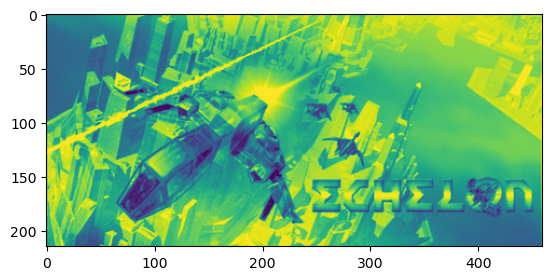

In [71]:
imgray = cv.imread('header.jpg',cv.IMREAD_GRAYSCALE)
plt.imshow(imgray)

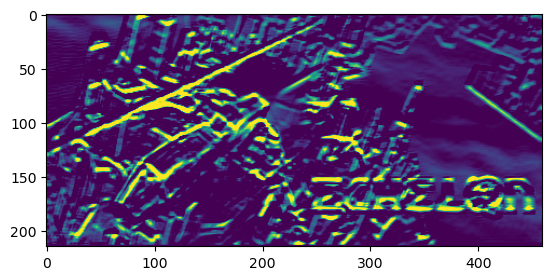

In [75]:
plt.imshow(cv.filter2D(imgray, -1, ker))

In [79]:
np.rot90(ker)

array([[ 1,  0,  0,  0, -1],
       [ 1,  0,  0,  0, -1],
       [ 1,  0,  0,  0, -1],
       [ 1,  0,  0,  0, -1],
       [ 1,  0,  0,  0, -1]], dtype=int8)

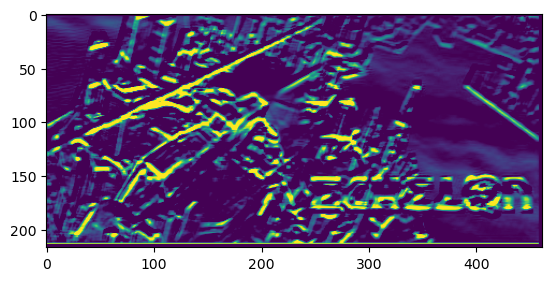

In [147]:
plt.imshow(convolve(imgray, ker,pudding=2,stride=1))

In [23]:
np.sum(np.convolve(imgray[:5,:5].flatten(),np.flip(ker).flatten()))

0

In [50]:
imgray.shape

(215, 460)

In [31]:
np.median(convolve(imgray, ker))

0.0

In [36]:
np.arange(3)*np.arange(3)

array([0, 1, 4])

In [142]:
b = applyPudding(a,2)
b

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 250, 251, 252, 253, 254,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0]], dtype=uint8)

In [138]:
a = np.zeros((5,5),dtype=np.uint8)
a[0,:] = np.arange(5)+250
a

array([[250, 251, 252, 253, 254],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0]], dtype=uint8)

In [143]:
cv.filter2D(b, -1, ker)

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [255, 255, 255, 255, 255, 255, 255, 255, 255],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0]], dtype=uint8)

In [144]:
cv.filter2D(a, -1, ker)

array([[  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0],
       [255, 255, 255, 255, 255],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0]], dtype=uint8)

In [100]:
convolve(a,ker,1,pudding=2)

(5, 5)


array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]], dtype=uint8)

In [102]:
b = applyPudding(a,2)

In [103]:
applyKernel(b[2:7,2:7],ker)

10.0

In [104]:
b[2:7,2:7]

array([[0., 1., 2., 3., 4.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [118]:
b[:20,:20]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 2., 3., 4., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])